<h1>K-Means</h1>

In [2]:
library(mlr)
source('../utils.r')

set.seed(42)

folder_name = '../../raw_data' 
file_name   = 'data.csv'

In [3]:
data = read.csv(file=sprintf('%s/%s',folder_name,file_name))

In [4]:
cat(sprintf('NRow: %d\nNCol: %d',nrow(data), ncol(data)))
head(data)

NRow: 3000
NCol: 3

V1,V2,V3
-0.3864836,-1.0888818,-1.3447766
-1.1540475,-1.0120354,-0.8063778
-0.3296713,-0.9588496,-1.1915773
-0.4763294,-1.3228970,-1.0150141
-0.2808378,-0.9671094,-0.7930474
-1.4089954,-1.2206403,-0.4905951


In [5]:
drops = c()
data  = data[ , !(names(data) %in% drops)]
cat(sprintf('NRow: %d\nNCol: %d',nrow(data), ncol(data)))

NRow: 3000
NCol: 3

In [6]:
cl = "cluster.kmeans"

In [7]:
getParamSet(cl)

              Type len           Def                             Constr Req
centers    untyped   -             -                                  -   -
iter.max   integer   -            10                           1 to Inf   -
nstart     integer   -             1                           1 to Inf   -
algorithm discrete   - Hartigan-Wong Hartigan-Wong,Lloyd,Forgy,MacQueen   -
trace      logical   -             -                                  -   -
          Tunable Trafo
centers      TRUE     -
iter.max     TRUE     -
nstart       TRUE     -
algorithm    TRUE     -
trace       FALSE     -

In [19]:
learner = makeLearner(cl = cl
                     , par.vals = list(
                          centers = 10
                         ,iter.max = 100
                         ,nstart = 1
                         ,trace = FALSE
                     )
                     )

In [20]:
task = makeClusterTask(id = deparse(substitute(data))
                      ,data = data
                      ,weights = NULL
                      ,blocking = NULL
                      ,fixup.data = "no"
                      ,check.data = TRUE)

In [21]:
model = mlr::train(learner,task)

In [15]:
measures = list(db
               ,dunn 
               ,G1
               ,G2
               ,silhouette 
               ,timetrain
               )

In [16]:
r = resample(learner = learner
            ,task = task 
            ,measures = measures
            #---------------------#
            ,models = TRUE
            ,keep.pred = FALSE
            ,show.info = TRUE
            )

ERROR: Error in inherits(resampling, "ResampleDesc"): argumento "resampling" ausente, sem padrão


<h2>1.Caso o número de cluster (k) seja fornecido</h2>

In [5]:
k = 3

Calcula o algoritmo Kmeans fornecendo somente quantos cluster estão presentes. Neste contexto a inicialização dos centroides serão aleatória.
* centers = 3 - Número de centroides
* nstart = 10 - Número de inicializações que será executada para garantir convergência
* iter.max = 100 - Número máximo de iterações do algoritmo KMeans

In [6]:
cluster = kmeans(data, 
                 centers=k, 
                 nstart = 10, 
                 iter.max = 100)

Plot do resultado: Observe que o plot é bidimensional, i.e., caso o dado possua mais de duas dimensões algumas não serão visualizadas.

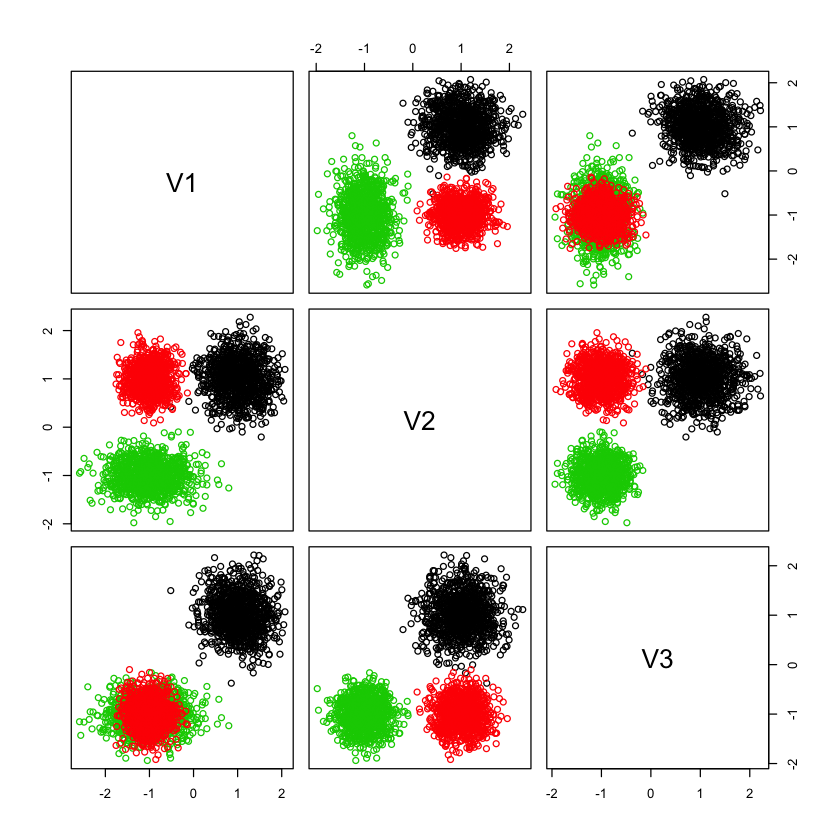

In [8]:
plot(data, col = cluster$cluster)

Posição final dos centroides

In [9]:
cluster$centers

,V1,V2,V3
1,1.0132657,1.018280,1.013927
2,-0.9974391,1.011304,-0.995262
3,-1.0077315,-1.003471,-1.007584


Número de elementos em cada grupo

In [10]:
cluster$size

[1] 1000 1000 1000

Número total de iterações até convergência

In [11]:
cluster$iter

[1] 2

<h2>2.Caso a posição inicial dos centroides seja fornecida</h2>

In [12]:
centroides = matrix(c( 1.00,  1.00, -1.00,
                      -1.00, -1.00, -1.00,
                       1.00,  1.00,  1.00),
                    byrow=T,
                    ncol = 3,#Número de colunas igual ao número de dimensões dos dados
                    nrow = 3)#Número de linhas igual ao número de clusters presentes na base

In [13]:
cluster = kmeans(data, 
                 centers=centroides, 
                 nstart = 10, 
                 iter.max = 100)

Plot do resultado: Observe que o plot é bidimensional, i.e., caso o dado possua mais de duas dimensões algumas não serão visualizadas.

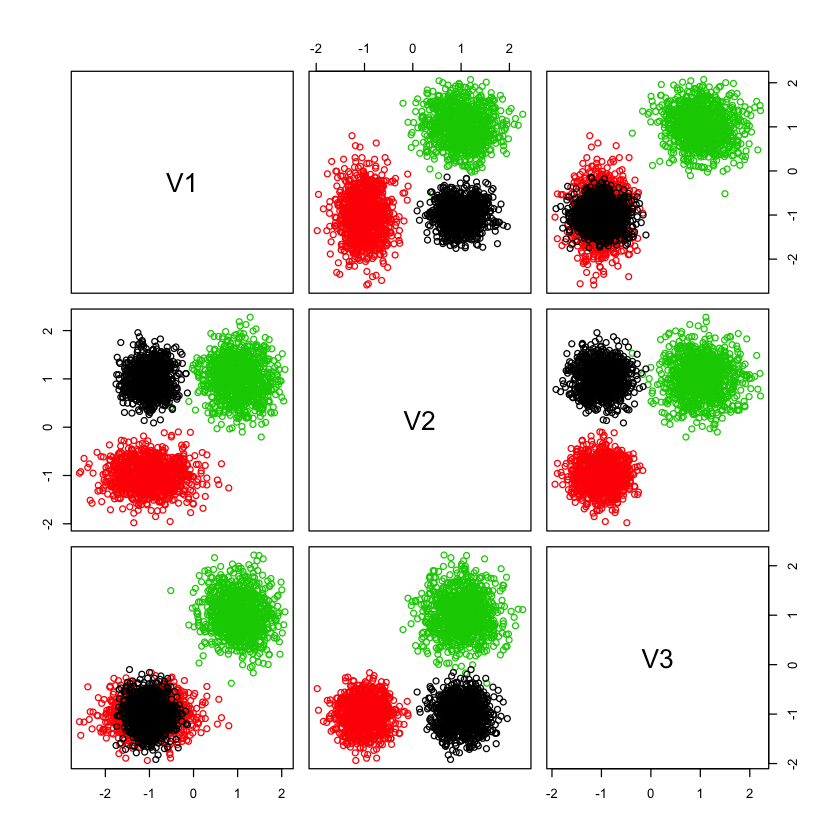

In [15]:
plot(data, col = cluster$cluster)

Posição final dos centroides

In [16]:
cluster$centers

,V1,V2,V3
1,-0.9974391,1.011304,-0.995262
2,-1.0077315,-1.003471,-1.007584
3,1.0132657,1.018280,1.013927


Número de elementos em cada grupo

In [17]:
cluster$size

[1] 1000 1000 1000

Número total de iterações até convergência

In [18]:
cluster$iter

[1] 2

<h2>3.Caso somente os dados sejam fornecidos</h2>

In [21]:
k.max = 20

Dado o centroide do cluster c como:
$$
    \bar{x}_{c} = \frac{1}{C_{c}} \sum_{\substack{x_{j} \in C_{c}}}^{} x_{j}
$$

Podemos calcular a soma quadratica dos erros como:

$$
    SSE = \sum_{\substack{c=1}}^{k} \sum_{\substack{x_{j} \in C_{c}}}^{} d(x_{j}, \bar{x}_{c})^{2}
$$


In [22]:
sse = c()
for(k in 1:k.max){
    cluster = kmeans(data, k, nstart=50, iter.max = 100)
    sse = c(sse, cluster$tot.withinss)
}

Para identificar o número ideal de clusters, é necessário encontrar o ponto de maior variação. Este, tipicamente, denominado "joelho"

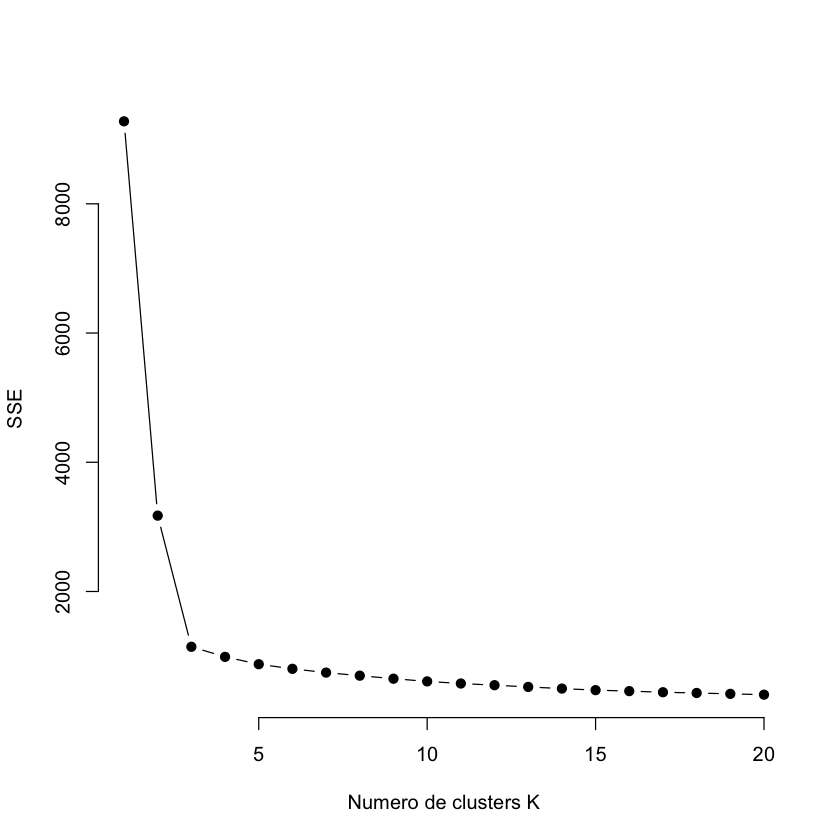

In [23]:
plot(1:k.max, sse,
     type="b", pch = 19, frame = FALSE, 
     xlab="Numero de clusters K",
     ylab="SSE")

Apesar da análise visual do gráfico auxiliar, é necessário encontrar algo que torne a estimação do k ideal automática. Com este objetivo, pode-se utilizar a derivada e encontrar o ponto de máxima variação:

$$
 \Delta SSE(k)=abs\left(\frac{SSE(k-1)-SSE(k)}{SSE(k)-SSE(k+1)}\right)
$$

In [24]:
ssed = c()
for(i in 2:(k.max-1)){
    ssed = c(ssed, abs((sse[i-1] - sse[i])/(sse[i] - sse[i+1])))
}

Como é possível verificar, há um "pico"no gráfico exatamente no número de clusters ideal estimado.

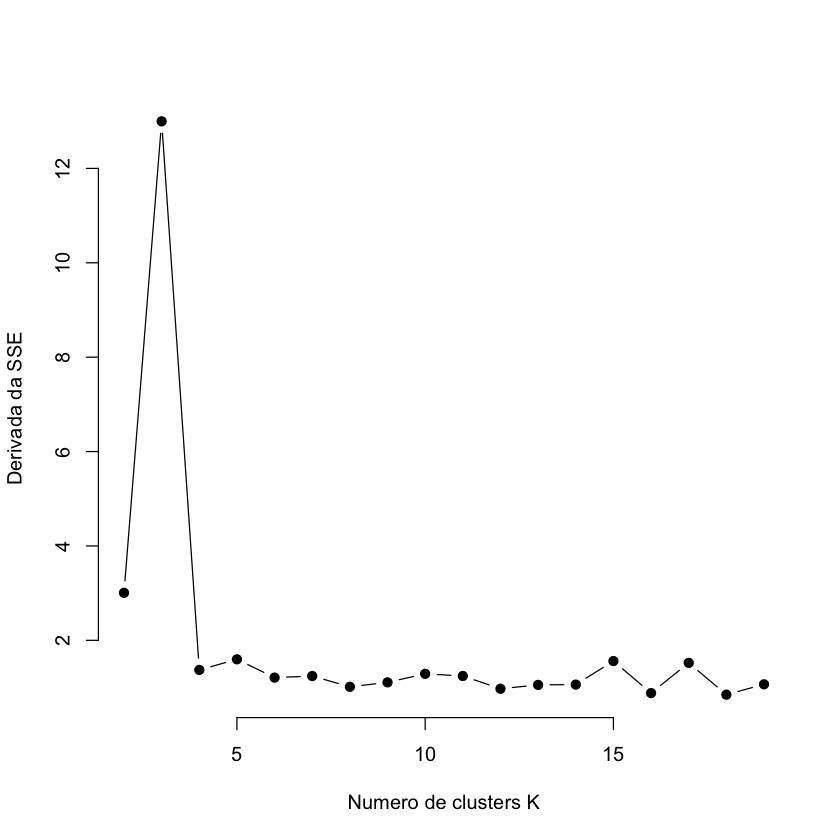

In [30]:
plot(2:(k.max-1), ssed,
     type="b", pch = 19, frame = FALSE, 
     xlab="Numero de clusters K",
     ylab="Derivada da SSE")

Com a quantidade de cluster estimada, tem-se então o K* (k_estrela) e já é possível calcular o algoritmo

In [31]:
k_estrela = which.max(ssed)+1

Calculo do Kmeans com o valor de K*

In [32]:
cluster = kmeans(data, 
                 centers=k_estrela, 
                 nstart = 10, 
                 iter.max = 100)

Plot do resultado: Observe que o plot é bidimensional, i.e., caso o dado possua mais de duas dimensões algumas não serão visualizadas.

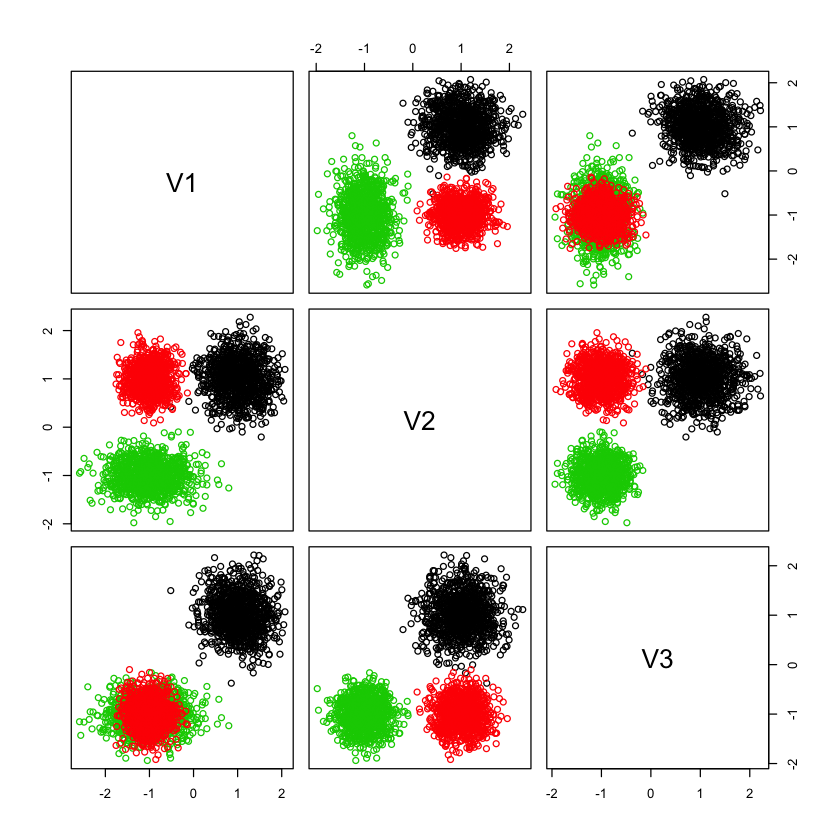

In [33]:
plot(data, col = cluster$cluster)

Posição final dos centroides

In [34]:
cluster$centers

,V1,V2,V3
1,1.0132657,1.018280,1.013927
2,-0.9974391,1.011304,-0.995262
3,-1.0077315,-1.003471,-1.007584


Número de elementos em cada grupo

In [35]:
cluster$size

[1] 1000 1000 1000

Número total de iterações até convergência

In [36]:
cluster$iter

[1] 2